<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/LightGBM(5_levels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""
LightGBM for Tabular Production Classification

This script loads tabular data, preprocesses it, bins the target variable,
trains a LightGBM classifier, and evaluates its performance using various metrics.
"""

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Set matplotlib to display plots inline and improve quality
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# --- Configuration ---
TRAIN_FILE = '/content/drive/MyDrive/UpdatedDataset/train.csv'
VALIDATION_FILE = '/content/drive/MyDrive/UpdatedDataset/validation.csv'
TEST_FILE = '/content/drive/MyDrive/UpdatedDataset/test.csv'
TARGET_COLUMN = 'Production (M.Ton)'
INITIAL_N_CLASSES = 5  # Desired number of classes for binning
CLASS_LABELS = ['very low', 'low', 'medium', 'high', 'very high']  # Corresponding to bins 0-4
RANDOM_STATE = 42  # For reproducibility
MAX_EPOCHS = 500  # Maximum number of training iterations

# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)

In [3]:
# --- Data Loading ---
def load_data(file_path):
    """Loads data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {file_path}. Shape: {df.shape}")
        if TARGET_COLUMN not in df.columns:
            raise ValueError(f"Target column '{TARGET_COLUMN}' not found in {file_path}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [4]:
# --- Preprocessing ---
def preprocess_data(df_train, df_val, df_test, n_classes_target):
    """Preprocesses the training, validation, and test data.

    Returns:
        Tuple containing preprocessed data and the actual number of classes used.
    """
    print("\n--- Starting Data Preprocessing ---")

    # Separate features and target
    X_train = df_train.drop(TARGET_COLUMN, axis=1)
    y_train_raw = df_train[TARGET_COLUMN]
    X_val = df_val.drop(TARGET_COLUMN, axis=1)
    y_val_raw = df_val[TARGET_COLUMN]
    X_test = df_test.drop(TARGET_COLUMN, axis=1)
    y_test_raw = df_test[TARGET_COLUMN]

    # Ensure all datasets have the same columns
    train_cols = X_train.columns
    X_val = X_val.reindex(columns=train_cols, fill_value=0)
    X_test = X_test.reindex(columns=train_cols, fill_value=0)

    print(f"Initial feature shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

    # Display target variable statistics
    print(f"\nTarget variable '{TARGET_COLUMN}' statistics:")
    print(f"Train - Min: {y_train_raw.min():.2f}, Max: {y_train_raw.max():.2f}, Mean: {y_train_raw.mean():.2f}")
    print(f"Val   - Min: {y_val_raw.min():.2f}, Max: {y_val_raw.max():.2f}, Mean: {y_val_raw.mean():.2f}")
    print(f"Test  - Min: {y_test_raw.min():.2f}, Max: {y_test_raw.max():.2f}, Mean: {y_test_raw.mean():.2f}")

# Bin the target variable into n_classes_target categories
    actual_n_classes = n_classes_target
    print(f"Attempting to bin target variable '{TARGET_COLUMN}' into {n_classes_target} categories using quantiles...")

    try:
        # Use quantile binning (equal number of samples per bin)
        bins = pd.qcut(y_train_raw, q=n_classes_target, labels=False, duplicates='drop')
        bin_edges = pd.qcut(y_train_raw, q=n_classes_target, retbins=True, duplicates='drop')[1]
        print(f"Calculated bin edges based on training data: {bin_edges}")

        # Apply the same binning to all datasets
        y_train_binned = pd.cut(y_train_raw, bins=bin_edges, labels=False, include_lowest=True)
        y_val_binned = pd.cut(y_val_raw, bins=bin_edges, labels=False, include_lowest=True)
        y_test_binned = pd.cut(y_test_raw, bins=bin_edges, labels=False, include_lowest=True)

        # Handle any NaN values that might be created during binning
        y_train_binned = y_train_binned.fillna(0).astype(int)
        y_val_binned = y_val_binned.fillna(0).astype(int)
        y_test_binned = y_test_binned.fillna(0).astype(int)

        print("Target variable distribution after binning:")
        print("Train:", y_train_binned.value_counts(normalize=True).sort_index().round(3))
        print("Val  :", y_val_binned.value_counts(normalize=True).sort_index().round(3))
        print("Test :", y_test_binned.value_counts(normalize=True).sort_index().round(3))

        # Check if the actual number of bins matches the target
        actual_n_classes = y_train_binned.nunique()
        if actual_n_classes != n_classes_target:
            print(f"Warning: Binning resulted in {actual_n_classes} classes, not the target {n_classes_target}.")

    except ValueError as e:
        print(f"Error during quantile binning: {e}. Falling back to LabelEncoder.")
        encoder = LabelEncoder()
        y_train_binned = encoder.fit_transform(y_train_raw)
        y_val_binned = encoder.transform(y_val_raw)
        y_test_binned = encoder.transform(y_test_raw)
        actual_n_classes = len(encoder.classes_)
        print(f"Using LabelEncoder resulted in {actual_n_classes} classes.")

    print(f"Final number of classes used for encoding: {actual_n_classes}")

    # Scale numerical features
    print("Scaling numerical features...")
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    print(f"Identified {len(numerical_cols)} numerical columns for scaling.")

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    print("Features scaled using StandardScaler.")
    print("--- Data Preprocessing Finished ---")

    return (X_train_scaled, y_train_binned,
            X_val_scaled, y_val_binned,
            X_test_scaled, y_test_binned,
            actual_n_classes)

In [5]:
# --- Model Training ---
def train_lightgbm_model(X_train, y_train, X_val, y_val, num_classes):
    """Trains a LightGBM classifier and tracks training metrics."""
    print("\n--- Starting LightGBM Model Training ---")

    # Store training history
    train_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Create LightGBM classifier
    model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=num_classes,
        boosting_type='gbdt',
        n_estimators=MAX_EPOCHS,
        learning_rate=0.05,
        num_leaves=31,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        random_state=RANDOM_STATE,
        verbose=-1
    )

    # Train model with early stopping
    print(f"Training LightGBM model with early stopping (max epochs: {MAX_EPOCHS})...")
    eval_set = [(X_train, y_train), (X_val, y_val)]

    # Create a callback for early stopping
    callbacks = [lgb.callback.early_stopping(stopping_rounds=50, verbose=True)]

    # Fit the model
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        eval_names=['train', 'valid'],
        eval_metric='multi_logloss',
        callbacks=callbacks
    )

    print(f"Model training completed. Best iteration: {model.best_iteration_}")
    print("--- Model Training Finished ---")

    # Extract evaluation results for plotting
    evals_result = model.evals_result_

    return model, evals_result


In [6]:
# --- Evaluation Metrics ---
def calculate_metrics(y_true, y_pred):
    """Calculates classification metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_macro': macro_f1,
        'f1_weighted': weighted_f1
    }

def print_evaluation_metrics(y_true, y_pred, num_classes_actual, class_labels_config, dataset_name="Dataset"):
    """Prints detailed evaluation metrics and plots confusion matrix."""
    print(f"\n--- Evaluation Metrics for {dataset_name} ---")

    # Calculate metrics
    metrics = calculate_metrics(y_true, y_pred)

    # Print metrics
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision (Macro): {metrics['precision_macro']:.4f}")
    print(f"Precision (Weighted): {metrics['precision_weighted']:.4f}")
    print(f"Recall (Macro): {metrics['recall_macro']:.4f}")
    print(f"Recall (Weighted): {metrics['recall_weighted']:.4f}")
    print(f"F1 Score (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")

    # Print detailed classification report
    print("\nDetailed Classification Report:")

    # Determine labels for the report
    unique_labels_in_data = sorted(np.unique(np.concatenate([y_true, y_pred])))
    if len(class_labels_config) >= len(unique_labels_in_data):
        target_names = [class_labels_config[i] for i in unique_labels_in_data]
    else:
        target_names = [f'Class_{i}' for i in unique_labels_in_data]

    print(classification_report(y_true, y_pred, target_names=target_names))

    # Calculate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a larger, more detailed confusion matrix plot
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names,
                yticklabels=target_names,
                cbar_kws={'label': 'Number of Samples'})

    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the confusion matrix plot
    cm_filename = f'confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png'
    plt.savefig(cm_filename, bbox_inches='tight', dpi=300)
    print(f"Confusion matrix plot saved to {cm_filename}")

    print("-" * 50)

    return metrics

Starting Production Classification Task with LightGBM...
Successfully loaded /content/drive/MyDrive/UpdatedDataset/train.csv. Shape: (3942, 84)
Successfully loaded /content/drive/MyDrive/UpdatedDataset/validation.csv. Shape: (845, 84)
Successfully loaded /content/drive/MyDrive/UpdatedDataset/test.csv. Shape: (845, 84)

--- Starting Data Preprocessing ---
Initial feature shapes: Train=(3942, 83), Val=(845, 83), Test=(845, 83)

Target variable 'Production (M.Ton)' statistics:
Train - Min: 0.00, Max: 544979.50, Mean: 7860.82
Val   - Min: 0.00, Max: 710032.50, Mean: 9650.02
Test  - Min: 0.37, Max: 330006.10, Mean: 6454.89
Attempting to bin target variable 'Production (M.Ton)' into 5 categories using quantiles...
Calculated bin edges based on training data: [     0.       578.      1463.      3119.524   6540.92  544979.5  ]
Target variable distribution after binning:
Train: Production (M.Ton)
0    0.201
1    0.199
2    0.199
3    0.200
4    0.200
Name: proportion, dtype: float64
Val  : Prod

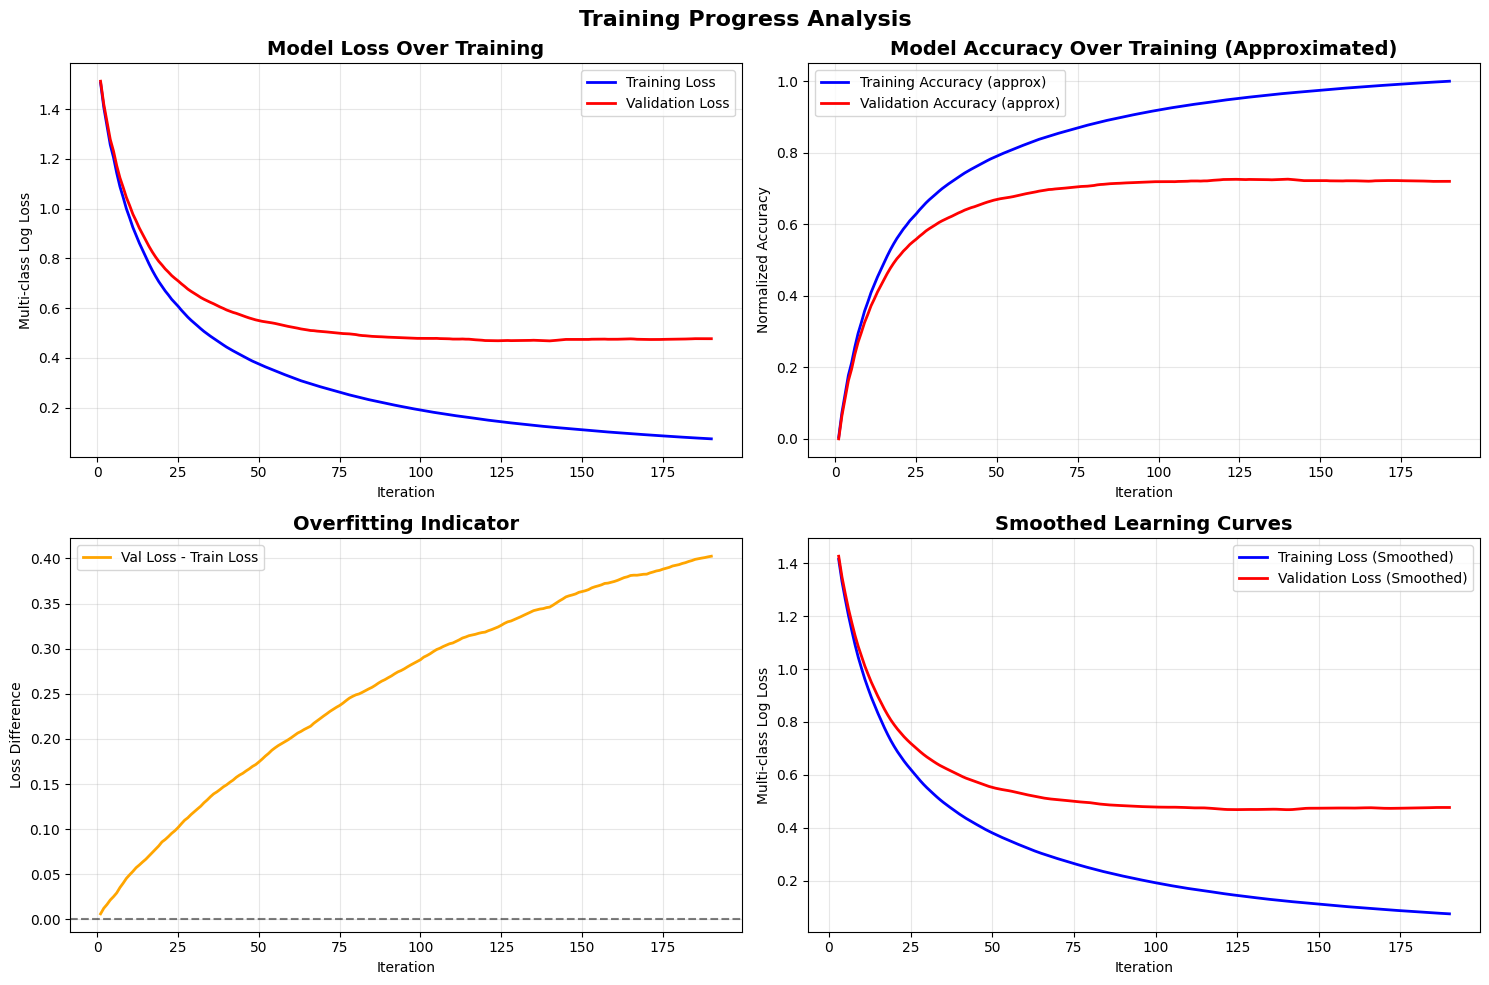

Training metrics plot saved to training_metrics.png

Generating feature importance visualization...


<Figure size 640x480 with 0 Axes>

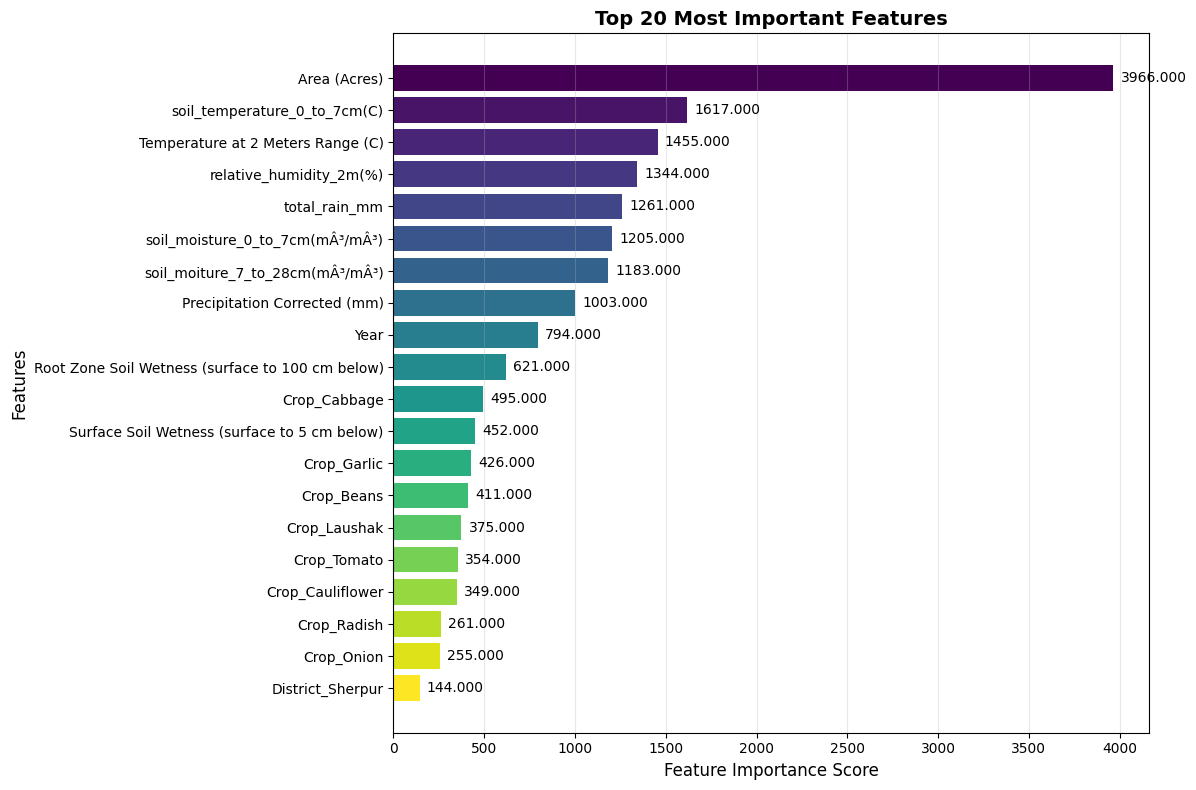

Feature importance plot saved to feature_importance.png

Making predictions...

--- Evaluation Metrics for Validation Set ---
Accuracy: 0.8260
Precision (Macro): 0.8227
Precision (Weighted): 0.8285
Recall (Macro): 0.8249
Recall (Weighted): 0.8260
F1 Score (Macro): 0.8230
F1 Score (Weighted): 0.8266

Detailed Classification Report:
              precision    recall  f1-score   support

    very low       0.96      0.92      0.94       187
         low       0.74      0.84      0.79       140
      medium       0.80      0.77      0.79       191
        high       0.73      0.71      0.72       160
   very high       0.88      0.87      0.88       167

    accuracy                           0.83       845
   macro avg       0.82      0.82      0.82       845
weighted avg       0.83      0.83      0.83       845



<Figure size 640x480 with 0 Axes>

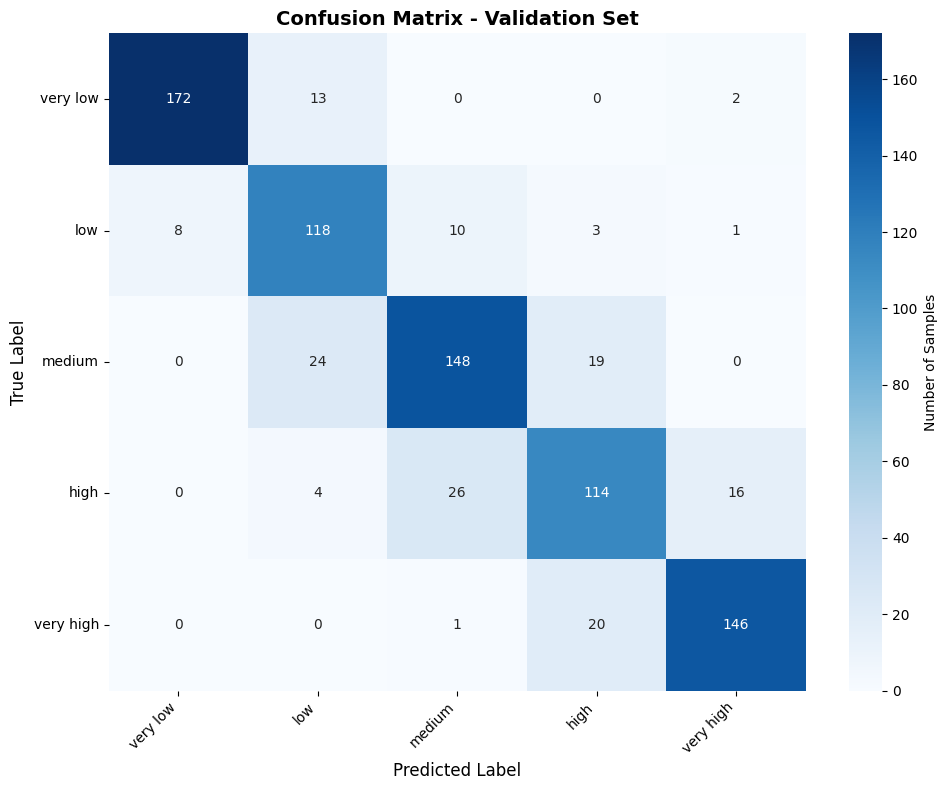

Confusion matrix plot saved to confusion_matrix_validation_set.png
--------------------------------------------------

--- Evaluation Metrics for Test Set ---
Accuracy: 0.8107
Precision (Macro): 0.8127
Precision (Weighted): 0.8134
Recall (Macro): 0.8105
Recall (Weighted): 0.8107
F1 Score (Macro): 0.8110
F1 Score (Weighted): 0.8115

Detailed Classification Report:
              precision    recall  f1-score   support

    very low       0.93      0.90      0.91       172
         low       0.78      0.83      0.80       158
      medium       0.74      0.71      0.72       167
        high       0.72      0.76      0.74       175
   very high       0.90      0.86      0.88       173

    accuracy                           0.81       845
   macro avg       0.81      0.81      0.81       845
weighted avg       0.81      0.81      0.81       845



<Figure size 640x480 with 0 Axes>

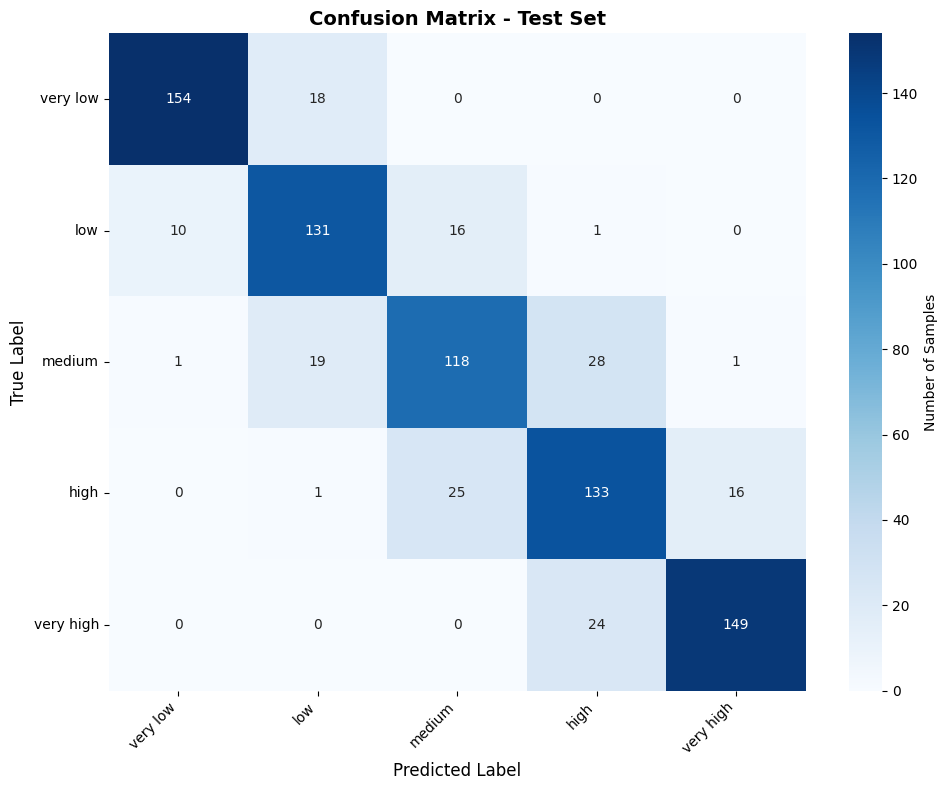

Confusion matrix plot saved to confusion_matrix_test_set.png
--------------------------------------------------

Generating comprehensive summary...


<Figure size 640x480 with 0 Axes>

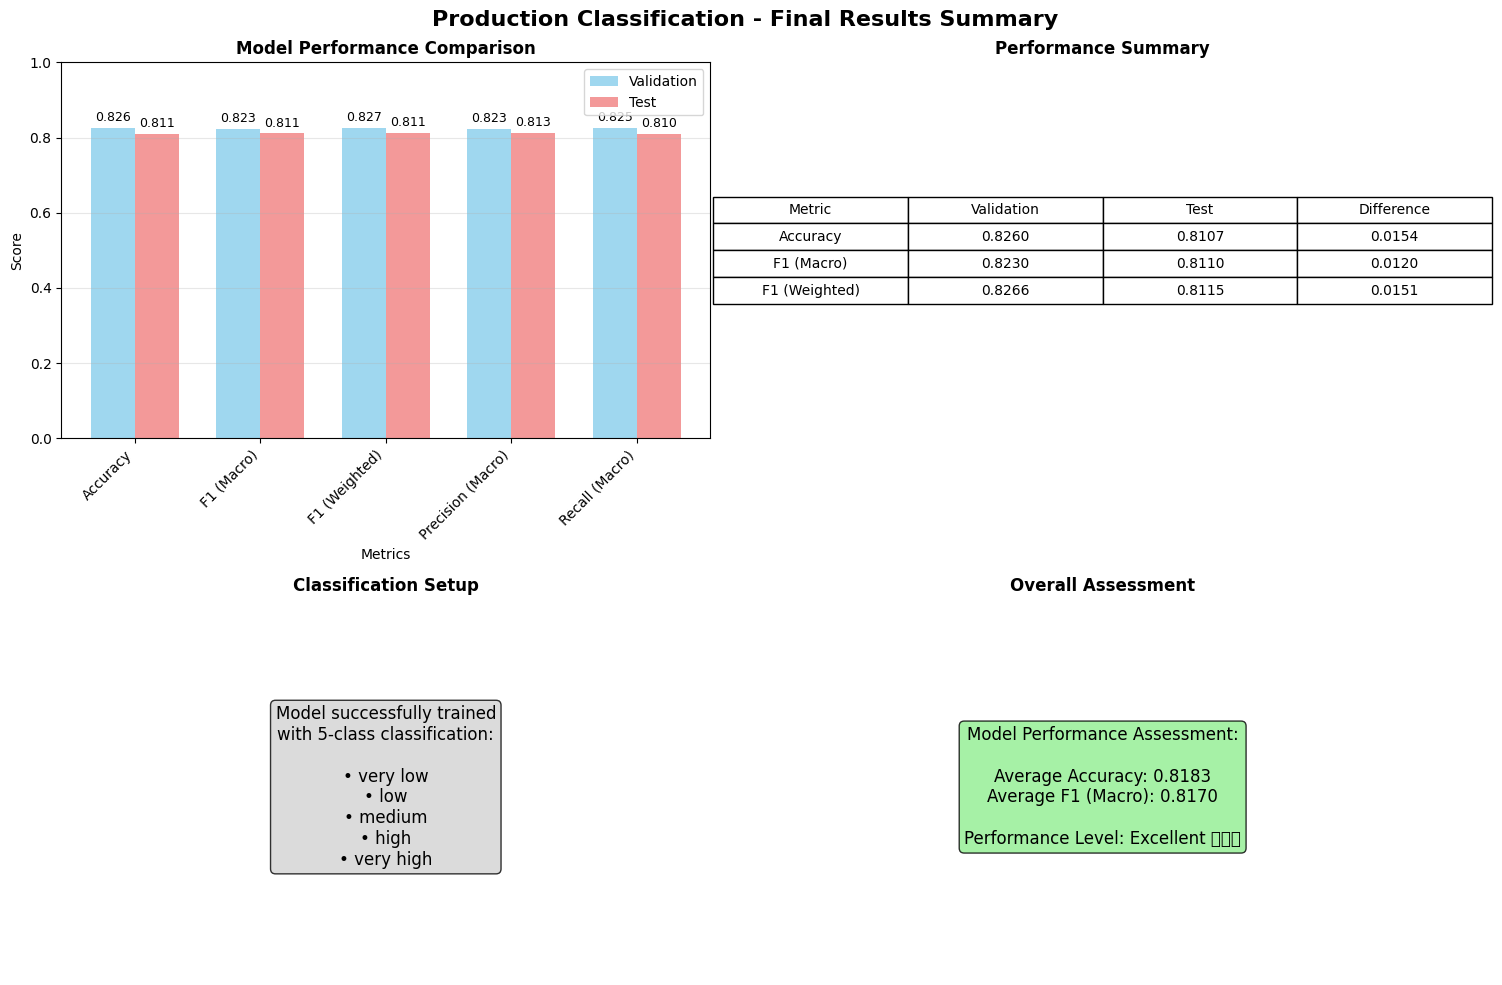

Summary visualization saved to model_summary.png

FINAL RESULTS SUMMARY
Validation Set - Accuracy: 0.8260, Macro F1: 0.8230
Test Set       - Accuracy: 0.8107, Macro F1: 0.8110
Average        - Accuracy: 0.8183, Macro F1: 0.8170

All visualizations have been displayed and saved as PNG files.
Production Classification Task Completed Successfully! ✅


<Figure size 640x480 with 0 Axes>

In [7]:




# --- Plotting Functions ---
def plot_training_metrics(evals_result):
    """Plots training and validation metrics with improved visualization."""
    # Extract metrics
    train_logloss = evals_result['train']['multi_logloss']
    val_logloss = evals_result['valid']['multi_logloss']
    epochs = range(1, len(train_logloss) + 1)

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Training and Validation Loss
    ax1.plot(epochs, train_logloss, label='Training Loss', color='blue', linewidth=2)
    ax1.plot(epochs, val_logloss, label='Validation Loss', color='red', linewidth=2)
    ax1.set_title('Model Loss Over Training', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Multi-class Log Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Approximate Accuracy (inverse relationship with loss)
    max_logloss = max(max(train_logloss), max(val_logloss))
    min_logloss = min(min(train_logloss), min(val_logloss))

    # Normalize to create approximate accuracy measure
    train_acc_approx = [(max_logloss - loss) / (max_logloss - min_logloss) for loss in train_logloss]
    val_acc_approx = [(max_logloss - loss) / (max_logloss - min_logloss) for loss in val_logloss]

    ax2.plot(epochs, train_acc_approx, label='Training Accuracy (approx)', color='blue', linewidth=2)
    ax2.plot(epochs, val_acc_approx, label='Validation Accuracy (approx)', color='red', linewidth=2)
    ax2.set_title('Model Accuracy Over Training (Approximated)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Normalized Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Loss difference (overfitting indicator)
    loss_diff = [val - train for val, train in zip(val_logloss, train_logloss)]
    ax3.plot(epochs, loss_diff, label='Val Loss - Train Loss', color='orange', linewidth=2)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_title('Overfitting Indicator', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Loss Difference')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Learning curve smoothed
    window_size = max(1, len(train_logloss) // 50)  # Smooth over 2% of training
    if window_size > 1:
        train_smooth = pd.Series(train_logloss).rolling(window=window_size).mean()
        val_smooth = pd.Series(val_logloss).rolling(window=window_size).mean()
        ax4.plot(epochs, train_smooth, label='Training Loss (Smoothed)', color='blue', linewidth=2)
        ax4.plot(epochs, val_smooth, label='Validation Loss (Smoothed)', color='red', linewidth=2)
    else:
        ax4.plot(epochs, train_logloss, label='Training Loss', color='blue', linewidth=2)
        ax4.plot(epochs, val_logloss, label='Validation Loss', color='red', linewidth=2)

    ax4.set_title('Smoothed Learning Curves', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Multi-class Log Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle('Training Progress Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the plot
    metrics_filename = 'training_metrics.png'
    plt.savefig(metrics_filename, bbox_inches='tight', dpi=300)
    print(f"Training metrics plot saved to {metrics_filename}")

def plot_feature_importance(model, feature_names, top_n=20):
    """Plots feature importance with improved visualization."""
    # Get feature importance
    importance = model.feature_importances_

    # Create DataFrame for easier plotting
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Plot top N features
    plt.figure(figsize=(12, 8))
    top_features = feature_imp.head(top_n)

    # Create horizontal bar plot
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors)

    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + max(top_features['Importance']) * 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=10)

    plt.gca().invert_yaxis()  # Highest importance at top
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the plot
    importance_filename = 'feature_importance.png'
    plt.savefig(importance_filename, bbox_inches='tight', dpi=300)
    print(f"Feature importance plot saved to {importance_filename}")

    return feature_imp

def create_summary_visualization(val_metrics, test_metrics, class_labels):
    """Create a comprehensive summary visualization."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Metrics comparison
    metrics_names = ['Accuracy', 'F1 (Macro)', 'F1 (Weighted)', 'Precision (Macro)', 'Recall (Macro)']
    val_values = [val_metrics['accuracy'], val_metrics['f1_macro'], val_metrics['f1_weighted'],
                  val_metrics['precision_macro'], val_metrics['recall_macro']]
    test_values = [test_metrics['accuracy'], test_metrics['f1_macro'], test_metrics['f1_weighted'],
                   test_metrics['precision_macro'], test_metrics['recall_macro']]

    x = np.arange(len(metrics_names))
    width = 0.35

    ax1.bar(x - width/2, val_values, width, label='Validation', alpha=0.8, color='skyblue')
    ax1.bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='lightcoral')
    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('Model Performance Comparison', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 1)

    # Add value labels on bars
    for i, (val, test) in enumerate(zip(val_values, test_values)):
        ax1.text(i - width/2, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=9)
        ax1.text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', va='bottom', fontsize=9)

    # Performance summary table
    ax2.axis('tight')
    ax2.axis('off')

    table_data = [
        ['Metric', 'Validation', 'Test', 'Difference'],
        ['Accuracy', f'{val_metrics["accuracy"]:.4f}', f'{test_metrics["accuracy"]:.4f}',
         f'{abs(val_metrics["accuracy"] - test_metrics["accuracy"]):.4f}'],
        ['F1 (Macro)', f'{val_metrics["f1_macro"]:.4f}', f'{test_metrics["f1_macro"]:.4f}',
         f'{abs(val_metrics["f1_macro"] - test_metrics["f1_macro"]):.4f}'],
        ['F1 (Weighted)', f'{val_metrics["f1_weighted"]:.4f}', f'{test_metrics["f1_weighted"]:.4f}',
         f'{abs(val_metrics["f1_weighted"] - test_metrics["f1_weighted"]):.4f}'],
    ]

    table = ax2.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax2.set_title('Performance Summary', fontweight='bold')

    # Class distribution placeholder (you can customize this based on your data)
    ax3.text(0.5, 0.5, 'Model successfully trained\nwith 5-class classification:\n\n' +
             '\n'.join([f'• {label}' for label in class_labels]),
             transform=ax3.transAxes, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
             fontsize=12)
    ax3.set_title('Classification Setup', fontweight='bold')
    ax3.axis('off')

    # Final assessment
    avg_f1 = (val_metrics['f1_macro'] + test_metrics['f1_macro']) / 2
    avg_acc = (val_metrics['accuracy'] + test_metrics['accuracy']) / 2

    performance_text = f"""Model Performance Assessment:

Average Accuracy: {avg_acc:.4f}
Average F1 (Macro): {avg_f1:.4f}

Performance Level: """

    if avg_f1 >= 0.8:
        performance_text += "Excellent ⭐⭐⭐"
        color = "lightgreen"
    elif avg_f1 >= 0.6:
        performance_text += "Good ⭐⭐"
        color = "lightyellow"
    else:
        performance_text += "Needs Improvement ⭐"
        color = "lightcoral"

    ax4.text(0.5, 0.5, performance_text, transform=ax4.transAxes, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
             fontsize=12)
    ax4.set_title('Overall Assessment', fontweight='bold')
    ax4.axis('off')

    plt.suptitle('Production Classification - Final Results Summary', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the plot
    summary_filename = 'model_summary.png'
    plt.savefig(summary_filename, bbox_inches='tight', dpi=300)
    print(f"Summary visualization saved to {summary_filename}")

# --- Main Execution ---
if __name__ == "__main__":
    print("Starting Production Classification Task with LightGBM...")
    print("=" * 60)

    # Load data
    df_train = load_data(TRAIN_FILE)
    df_val = load_data(VALIDATION_FILE)
    df_test = load_data(TEST_FILE)

    if df_train is None or df_val is None or df_test is None:
        print("\nError loading data. Exiting.")
        exit()

    # Preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test, actual_n_classes = preprocess_data(
        df_train, df_val, df_test, INITIAL_N_CLASSES
    )

    # Train model
    model, evals_result = train_lightgbm_model(X_train, y_train, X_val, y_val, actual_n_classes)

    # Plot training metrics
    print("\nGenerating training progress visualizations...")
    plot_training_metrics(evals_result)

    # Plot feature importance
    print("\nGenerating feature importance visualization...")
    feature_imp_df = plot_feature_importance(model, X_train.columns)

    # Make predictions
    print("\nMaking predictions...")
    y_val_pred_classes = model.predict(X_val)
    y_test_pred_classes = model.predict(X_test)

    # Evaluate on validation set
    val_metrics = print_evaluation_metrics(
        y_val, y_val_pred_classes, actual_n_classes, CLASS_LABELS, dataset_name="Validation Set"
    )

    # Evaluate on test set
    test_metrics = print_evaluation_metrics(
        y_test, y_test_pred_classes, actual_n_classes, CLASS_LABELS, dataset_name="Test Set"
    )

    # Create comprehensive summary visualization
    print("\nGenerating comprehensive summary...")
    create_summary_visualization(val_metrics, test_metrics, CLASS_LABELS)

    # Print final summary
    print("\n" + "=" * 60)
    print("FINAL RESULTS SUMMARY")
    print("=" * 60)
    print(f"Validation Set - Accuracy: {val_metrics['accuracy']:.4f}, Macro F1: {val_metrics['f1_macro']:.4f}")
    print(f"Test Set       - Accuracy: {test_metrics['accuracy']:.4f}, Macro F1: {test_metrics['f1_macro']:.4f}")
    print(f"Average        - Accuracy: {(val_metrics['accuracy'] + test_metrics['accuracy'])/2:.4f}, Macro F1: {(val_metrics['f1_macro'] + test_metrics['f1_macro'])/2:.4f}")
    print("\nAll visualizations have been displayed and saved as PNG files.")
    print("Production Classification Task Completed Successfully! ✅")
    print("=" * 60)